# Neural Network in Numpy with MNIST Example

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

** NN Parameter Initialization **

In [2]:
def initialization(layer_dims):
    """
    Initialize network parameters.

    Arguments:
    layers_dims -- python list containing the dimensions of each layer in the network
    
    Returns:
    parameters -- python dictionary containing the parameters "W1", "b1", "W2", "b2":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    input_layer=layer_dims[0]
    hidden_layer=layer_dims[1]
    output_layer=layer_dims[2]

    # Weight initialization with He Normal, biases initialized to zero
    W1 = np.random.randn(hidden_layer, input_layer) * np.sqrt(2/input_layer)
    b1 = np.zeros((hidden_layer, 1))
    W2 = np.random.randn(output_layer, hidden_layer) * np.sqrt(2/hidden_layer)
    b2 = np.zeros((output_layer, 1))
    

    parameters = {
        'W1': W1,
        'b1': b1,
        'W2': W2,
        'b2': b2
    }

    return parameters

** Forward Propagation Module **

In [3]:
# Helper functions - ReLU and softmax activation fuctions

def relu(x, derivative = False):
    if derivative:
        return x >= 0
    return (x >= 0) * x

def softmax(x):
    exps = np.exp(x)
    return exps / np.sum(exps, axis=0) 

In [4]:
def forward_pass(X, parameters, dropout = False, dropout_keep_prob = 0.5):
    """
    Forward propagation for the LINEAR->RELU->DROPOUT(optional)->LINEAR->SOFTMAX computation.
    
    Arguments:
    X -- input data, numpy array of shape (input size, number of examples)
    parameters -- output of initialization()
    dropout -- enable/disable (True/False) dropout regularization
    dropout_keep_prob - probability of keeping a neuron active during drop-out, scalar
    
    Returns:
    A2 -- probability vector corresponding to label predictions, shape (output size, number of
    examples)
    caches -- tuple, information stored for computing the backward propagation
    """

    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    D1 = 0

    # input layer activations 
    A0 = X

    # input layer to hidden layer
    Z1 = np.dot(W1, A0) + b1
    A1 = relu(Z1)

    # optional dropout regularization
    if dropout:
        # initialize dropout mask
        D1 = np.random.rand(A1.shape[0],A1.shape[1])    
        # convert entries of D1 to 0 or 1 (using keep_prob as the threshold)            
        D1 = (D1 < dropout_keep_prob).astype(int)   
        # shut down some neurons of A1                                  
        A1 = A1 * D1  
        # scale the value of neurons that haven't been shut down                                    
        A1 = A1 / dropout_keep_prob

    # hidden layer to output layer 
    Z2 = np.dot(W2, A1) + b2
    A2 = softmax(Z2)

    cache = (Z1, D1, dropout_keep_prob, A1, W1, b1, Z2, A2, W2, b2)

    return A2, cache

In [5]:
def compute_cost(A2, Y):
    """
    Computes the cross entropy cost function.

    Arguments:
    A2 -- probability vector corresponding to label predictions, shape (output size, number of
    examples)
    Y -- true "label" vector, shape (output size, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    cost = - np.sum(Y * np.log(A2))
    cost = np.squeeze(cost)      

    return cost

In [6]:
def compute_accuracy(A2, Y):
    """
    Computes model accuracy. 

    Arguments:
    A2 -- probability vector corresponding to label predictions, shape (output size, number of
    examples)
    Y -- "true" labels vector, of shape (output size, number of examples)
    
    Returns:
    accuracy -- model accuracy  
    """
    accuracy = (np.argmax(A2, axis = 0) == np.argmax(Y, axis = 0)).mean()

    return accuracy

** Backward Propagation Module **

In [7]:
def backward_pass(X, Y, cache, dropout = False):
    """
    Backward propagation implementation.
    
    Arguments:
    X -- input data, numpy array of shape (input size, number of examples)
    Y -- "true" labels vector, of shape (output size, number of examples)
    cache -- cache output from forward_pass()
    dropout -- enable/disable (True/False) dropout regularization
    
    Returns:
    gradients -- dictionary with gradients with respect to each parameter, activation 
    and pre-activation variables
    """
    (Z1, D1, dropout_keep_prob, A1, W1, b1, Z2, A2, W2, b2) = cache
    m = Y.shape[1]

    dZ2 = A2 - Y
    dW2 = 1./m * np.dot(dZ2, A1.T)
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)
    dA1 = np.dot(W2.T, dZ2)

    if dropout:
        dA1 = dA1 * D1              
        dA1 = dA1 / dropout_keep_prob             

    dZ1 = np.multiply(dA1, relu(Z1, derivative = True))
    dW1 = 1./m * np.dot(dZ1, X.T)
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)

    gradients = {"dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                    "dZ1": dZ1, "dW1": dW1, "db1": db1}

    return gradients

In [8]:
def update_network_parameters(parameters, gradients, learning_rate = 0.01):
    """
    Update parameters using gradient descent.
    
    Arguments:
    parameters -- python dictionary containing the parameters 
    gradients -- python dictionary containing the gradients, output of backward_pass()
    learning_rate -- learning rate of the gradient descent update rule
    
    Returns:
    parameters -- python dictionary containing the updated parameters 
    """       
    parameters['W2'] -= learning_rate*gradients['dW2']
    parameters['b2'] -= learning_rate*gradients['db2']
    parameters['W1'] -= learning_rate*gradients['dW1']
    parameters['b1'] -= learning_rate*gradients['db1']

    return parameters

** Minibatch Implementation **

In [9]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y).
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector, of shape (output size, number of examples)
    mini_batch_size -- size of the mini-batches, integer
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    np.random.seed(seed)       
    m = Y.shape[1]                  
    mini_batches = []
        
    # Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation]

    # Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = m // mini_batch_size # number of mini batches of size mini_batch_size in partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k*mini_batch_size : (k+1)*mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k*mini_batch_size : (k+1)*mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches*mini_batch_size : ]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches*mini_batch_size : ]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [10]:
def nn_model(X, Y, layer_dims = [784, 256, 10], epochs = 100, mini_batch_size = 64, learning_rate = 0.1, dropout = False, dropout_keep_prob = 0.5):
    """
    Implements two-layer neural network: LINEAR->RELU->DROPOUT(optional)->LINEAR->SOFTMAX.
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector, of shape (output size, number of examples)
    layer_dims -- dimensions of the layers (input layer, hidden layer, output layer)
    epochs -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule 
    mini_batch_size -- size of the mini-batches, integer
    dropout -- enable/disable (True/False) dropout regularization
    dropout_keep_prob - probability of keeping a neuron active during drop-out, scalar
    
    Returns:
    parameters -- a dictionary containing the parameters learnt by the model during training
    """

    parameters = initialization(layer_dims)
    cost_history = []
    accuracy_history = []
    start_time = time.time()
    seed = 0
    m = Y.shape[1]
    num_mini_batches = np.ceil(m / mini_batch_size)

    for epoch in range(0, epochs):

        seed = seed + 1
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)
        cost_total = 0
        accuracy_total = 0

        for minibatch in minibatches:

            # Select a minibatch
            (minibatch_X, minibatch_Y) = minibatch

            A2, cache = forward_pass(minibatch_X, parameters, dropout, dropout_keep_prob)
            cost_total += compute_cost(A2, minibatch_Y)
            accuracy_total += compute_accuracy(A2, minibatch_Y)
            gradients = backward_pass(minibatch_X, minibatch_Y, cache, dropout)
            parameters = update_network_parameters(parameters, gradients, learning_rate)
        
        cost_avg = cost_total / m
        cost_history.append(cost_avg)
        accuracy_avg = accuracy_total / num_mini_batches
        accuracy_history.append(accuracy_avg)

        if epoch % 10 == 0:
            print ("Cost after iteration %i: %f" %(epoch, cost_avg))
            print ("Accuracy after iteration %i: %f" %(epoch, accuracy_avg))
    
    print('Time Spent: {:.2f}s'.format(time.time() - start_time))

    # Plot cost and accuracy 
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Cost', color=color)
    ax1.plot(cost_history, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  

    color = 'tab:blue'
    ax2.set_ylabel('Accuracy', color=color)  
    ax2.plot(accuracy_history, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout() 
    plt.show()

    return parameters

** Evaluate Trained Model Performance **

In [11]:
def evaluate_model(parameters, X_test, Y_test):
    """
    Evaluate the trained model performance on test set.

    Arguments:
    parameters -- a dictionary containing the parameters learnt by the model during training
    X_test -- input data, of shape (input size, number of examples)
    Y_test -- true "label" vector, of shape (output size, number of examples)
    
    Returns:
    A2 -- probability vector corresponding to label predictions, shape (output size, number of
    examples)
    mislabelled_examples -- python list containing the indices of the mislabelled examples (useful
    for plotting and evaluation of the model)
    """

    m = Y_test.shape[1]
    A2, cache = forward_pass(X_test, parameters)
    predictions = np.argmax(A2, axis = 0)
    true_labels = np.argmax(Y_test, axis = 0)
    mislabelled_images = []

    for i in range(m):
        if predictions[i] != true_labels[i]:
            mislabelled_images.append(i)

    cost = (1 / m) * compute_cost(A2, Y_test)
    accuracy = compute_accuracy(A2, Y_test)
    print ("Cost: %f" %(cost))
    print ("Accuracy: %f" %(accuracy))

    return A2, mislabelled_images

# Import Example Dataset - MNIST

In [12]:
from tensorflow.keras.datasets import mnist

In [13]:
(x_train_orig, y_train_orig), (x_test_orig, y_test_orig) = mnist.load_data()

In [14]:
print('The shape of training images: {} and training labels: {}'.format(x_train_orig.shape, y_train_orig.shape))
print('The shape of test images: {} and test labels: {}'.format(x_test_orig.shape, y_test_orig.shape))

The shape of training images: (60000, 28, 28) and training labels: (60000,)
The shape of test images: (10000, 28, 28) and test labels: (10000,)


** Flatten Images for NN input**

In [15]:
x_train_flatten = x_train_orig.reshape(x_train_orig.shape[0], -1).T
x_test_flatten = x_test_orig.reshape(x_test_orig.shape[0], -1).T

In [16]:
print('The shape of training images: {} and test images: {}'.format(x_train_flatten.shape, x_test_flatten.shape))

The shape of training images: (784, 60000) and test images: (784, 10000)


** Standardize image data to have feature values between 0 and 1. **



In [17]:
training_sample, test_sample = 60000, 10000 # select how much of the data to use
training_images = x_train_flatten[:,:training_sample] / 255
test_images = x_test_flatten[:,:test_sample] / 255

** One hot encode the labels **

In [18]:
def one_hot_encoding(labels, dimension=10):
    one_hot_labels = (labels[..., None] == np.arange(dimension)).T
    return one_hot_labels.astype(np.float64)

In [19]:
training_labels = one_hot_encoding(y_train_orig[:training_sample])
test_labels = one_hot_encoding(y_test_orig[:test_sample])

In [20]:
print('The shape of the training images: {} and the training labels: {}'.format(training_images.shape, training_labels.shape))
print('The shape of the test images: {} and the test labels: {}'.format(test_images.shape, test_labels.shape))

The shape of the training images: (784, 60000) and the training labels: (10, 60000)
The shape of the test images: (784, 10000) and the test labels: (10, 10000)


In [21]:
print('The data type of training labels: {}'.format(training_labels.dtype))
print('The data type of test labels: {}'.format(test_labels.dtype))

The data type of training labels: float64
The data type of test labels: float64


# Train Model

Cost after iteration 0: 1.027139
Accuracy after iteration 0: 0.748209
Cost after iteration 10: 0.248670
Accuracy after iteration 10: 0.931046
Cost after iteration 20: 0.189076
Accuracy after iteration 20: 0.947891
Cost after iteration 30: 0.153411
Accuracy after iteration 30: 0.957457
Cost after iteration 40: 0.128951
Accuracy after iteration 40: 0.964282
Cost after iteration 50: 0.111139
Accuracy after iteration 50: 0.969408
Cost after iteration 60: 0.097176
Accuracy after iteration 60: 0.973158
Cost after iteration 70: 0.086339
Accuracy after iteration 70: 0.976665
Cost after iteration 80: 0.077388
Accuracy after iteration 80: 0.979228
Cost after iteration 90: 0.070082
Accuracy after iteration 90: 0.981117
Time Spent: 154.74s


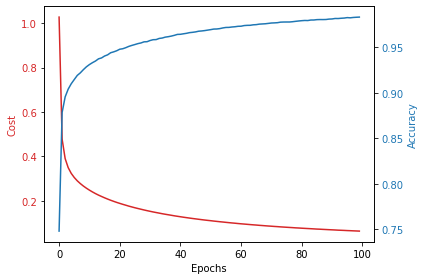

In [22]:
mnist_model = nn_model(training_images, training_labels, layer_dims = [784, 256, 10], epochs = 100, mini_batch_size = 1024, learning_rate = 0.1, dropout = False) 

# Evaluate Model on Test Set

In [23]:
predictions, mislabelled_examples = evaluate_model(mnist_model, test_images, test_labels)

Cost: 0.085017
Accuracy: 0.974000


# Study Model Predictions 

In [24]:
# Plot example image
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("Predicted {} {:2.0f}% (labelled {})".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label),
                                color=color)

# Plot model predictions
def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([0, 0.25, 0.5, 0.75, 1])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

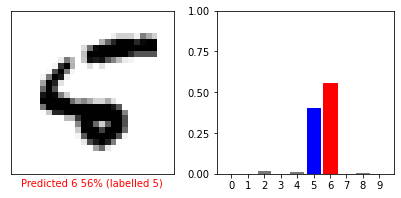

In [25]:
i = 8
plt.figure(figsize=(7,3))
plt.subplot(1,2,1)
plot_image(i, predictions[:,i], y_test_orig, x_test_orig)
plt.subplot(1,2,2)
plot_value_array(i, predictions[:,i],  y_test_orig)
plt.show()

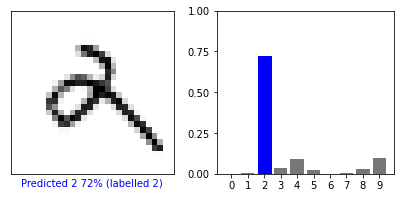

In [26]:
i = 149
plt.figure(figsize=(7,3))
plt.subplot(1,2,1)
plot_image(i, predictions[:,i], y_test_orig, x_test_orig)
plt.subplot(1,2,2)
plot_value_array(i, predictions[:,i],  y_test_orig)
plt.show()